### Student Information
Name: 詹詠吏

Student ID: 113065533

GitHub ID: h34091039

Kaggle name: yung-li, chan

Kaggle private scoreboard snapshot: 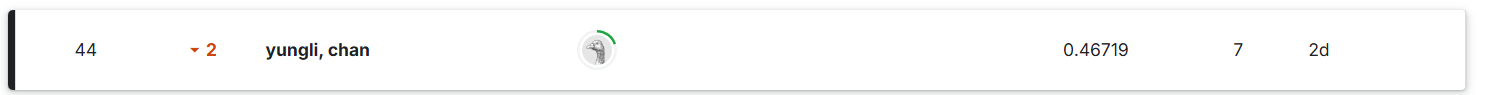

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

In [ ]:
### Begin Assignment Here

#import necessary package
%matplotlib inline

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import nltk

import gensim.downloader as api

import keras
import torch
from torch.utils.data import DataLoader, Dataset
from TweetNormalizer import normalizeTweet

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

from transformers import BertForSequenceClassification
from transformers import BertTokenizer
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
from transformers import AutoModel, AutoTokenizer
from transformers import AdamW

import wordsegment
from wordsegment import load, segment

import re
import inflect
import emoji

### Create pki file

In [ ]:
datas = []
with open('./dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as file:
    for l in file:
        datas.append(json.loads(l))

In [ ]:
label = pd.read_csv("./dm-2024-isa-5810-lab-2-homework/emotion.csv")
data_mapping = pd.read_csv("./dm-2024-isa-5810-lab-2-homework/data_identification.csv")

In [ ]:
D = pd.DataFrame(datas)
source = D["_source"].tolist()
source = pd.DataFrame(source)['tweet'].tolist()
source = pd.DataFrame(source)
source

,hashtags,tweet_id,text
0,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k..."
3,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,[],0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...,...
1867530,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...
1867531,[],0x29d0cb,I swear all this hard work gone pay off one da...
1867532,[],0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,[],0x24faed,"Ah, corporate life, where you can date <LH> us..."


In [ ]:
#merge data & label
D=D.drop(columns='_source')
D['hashtags'] = source['hashtags']
D['tweet_id'] = source['tweet_id']
D['text'] = source['text']
merged_df = pd.merge(D, data_mapping, left_on='tweet_id', right_on='tweet_id', how='left')
merged_df = pd.merge(merged_df, label, left_on='tweet_id', right_on='tweet_id', how='left')

merged_df

,_score,_index,_crawldate,_type,hashtags,tweet_id,text,identification,emotion
0,391,hashtag_tweets,2015-05-23 11:42:47,tweets,[Snapchat],0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,433,hashtag_tweets,2016-01-28 04:52:09,tweets,"[freepress, TrumpLegacy, CNN]",0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,232,hashtag_tweets,2017-12-25 04:39:20,tweets,[bibleverse],0x28b412,"Confident of your obedience, I write to you, k...",test,NaN
3,376,hashtag_tweets,2016-01-24 23:53:05,tweets,[],0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>,train,fear
4,989,hashtag_tweets,2016-01-08 17:18:59,tweets,[],0x2de201,"""Trust is not the same as faith. A friend is s...",test,NaN
...,...,...,...,...,...,...,...,...,...
1867530,827,hashtag_tweets,2015-05-12 12:51:52,tweets,"[mixedfeeling, butimTHATperson]",0x316b80,When you buy the last 2 tickets remaining for ...,test,NaN
1867531,368,hashtag_tweets,2017-10-02 17:54:04,tweets,[],0x29d0cb,I swear all this hard work gone pay off one da...,test,NaN
1867532,498,hashtag_tweets,2016-10-10 11:04:32,tweets,[],0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...,test,NaN
1867533,840,hashtag_tweets,2016-09-02 14:25:06,tweets,[],0x24faed,"Ah, corporate life, where you can date <LH> us...",train,joy


In [ ]:
#split training data & test data
training_data = merged_df[merged_df['identification']=='train']
testing_data = merged_df[merged_df['identification']=='test']

In [ ]:
# save as pickle
training_data.to_pickle("train_df.pkl") 
testing_data.to_pickle("test_df.pkl")

### Load pki file

In [ ]:
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

In [140]:
train_df=train_df.drop(columns=['_type', '_index', 'identification'])

### Category Distribution

In [ ]:
# the histogram of the data
labels = train_df['emotion'].unique()
post_total = len(train_df)
df1 = train_df.groupby(['emotion']).count()['text']
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(10,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution')
plt.grid(True)
plt.show()

### Preprocess (Manual Data Cleaning)

In [ ]:
load()

In [ ]:
def preprocess(train_df):
    '''
    manual preprocessing method
    1. remove tag
    2. remove <LH>
    3. split hashtag
    '''
    text_list = []
    for i in train_df['text']:
        sen = []
        for t in i.split():
            if '@' in t:
                sen.append(t[:t.index('@')])
                continue
            elif t == '<LH>':
                continue
            elif '#' in t:
                sen.append(t[:t.index('#')])
                tokens = segment(t[t.index('#'):])
                for t2 in tokens:
                    sen.append(t2)
            else:
                sen.append(t)
        merged_string = " ".join(sen)
        text_list.append(merged_string)
    train_df['text'] = text_list
    return train_df


In [ ]:
X_train = preprocess(train_df)
X_test = preprocess(test_df)

#### Vectorize Method 1 (BOW)

In [ ]:
BOW_vectorizer = CountVectorizer(tokenizer=nltk.word_tokenize) 
# 1. Learn a vocabulary dictionary of all tokens in the raw documents.
BOW_vectorizer.fit(X_train['text'])

In [ ]:
# for a classificaiton problem, you need to provide both training & testing data
X_train = BOW_vectorizer.transform(X_train['text'])
y_train = X_train['emotion']


X_test = BOW_vectorizer.transform(X_test['text'])

## take a look at data dimension is a good habit  :)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)

#### Vectorize Method 2 (glove-twitter-25)

In [ ]:
model = api.load("glove-twitter-25")

In [ ]:

p = inflect.engine()


def convert_number(match):
    '''Function to convert a number to words'''
    number = match.group(2)  # Extract the number part
    return f"{match.group(1)} {p.number_to_words(number)}"

def vectorize(X_train):
    '''
    map the token into the pretrain vector
    if not in pretrain model, do another preprocessing
    1. remove &gt
    2. convert emoji to token
    3. remove symbol
    '''
    a = X_train['text'].iloc
    X_train_vec = []
    for i in a[:]:
        vec = np.zeros(25)
        result = i.split()
        clean_text = ''
        vec_num = 0
        for i,sen in enumerate(result):
            if sen == '&gt;':
                sen = '>'
            hasEmoji = False
            emojisen = ''
            for x in sen:
                if x in emoji.EMOJI_DATA: 
                    x = emoji.demojize(x)
                    hasEmoji = True
                    emojisen+=x
                    emojisen+=' '
                else:
                    emojisen+=x
            sen = emojisen if hasEmoji else sen
            
            l = re.sub(r'([a-zA-Z])(\d+)',convert_number, sen)
            l = re.sub(r'[^\w\s]', '', l)
            clean_text+=l
            clean_text+= " "
            
        for s in clean_text:
            s = s.lower()
            if s and s!=" ":
                if s.isdigit():
                    s=p.number_to_words(s)
                if s in model:
                    vec += np.array(model.get_vector(s))
                    vec_num+=1
        X_train_vec.append(vec/vec_num)
    return X_train_vec
    

In [ ]:
X_train = vectorize(X_train)
X_test = vectorize(X_test)

### Preprocess (BERT)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
training_data = train_df['text'].tolist()

X_train = tokenizer(

    training_data,

    max_length=8,

    padding='max_length',

    truncation=True,

    return_tensors='pt'

)
y_train = train_df['emotion']

testing_data = test_df['text'].tolist()

X_test = tokenizer(

    testing_data,

    max_length=8,

    padding='max_length',

    truncation=True,

    return_tensors='pt'

)

### Preprocess(BERTweet)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=True)

In [ ]:
normalize = []
for i in train_df['text'].tolist():
    normalize.append(normalizeTweet(i))
train_df['text'] = normalize

In [ ]:
training_data = train_df['text'].tolist()

X_train = tokenizer(

    training_data,

    max_length=8,

    padding='max_length',

    truncation=True,

    return_tensors='pt'

)
y_train = train_df['emotion']

testing_data = test_df['text'].tolist()

X_test = tokenizer(

    testing_data,

    max_length=8,

    padding='max_length',

    truncation=True,

    return_tensors='pt'

)

### Labeling (one-hot encoding)

In [ ]:
## deal with label (string -> one-hot)

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train_sample = label_encode(label_encoder, y_train)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train_sample[0:4])
print('\ny_train.shape: ', y_train_sample.shape)



### Train Model

#### Decision Tree

In [ ]:
## build DecisionTree model
DT_model = DecisionTreeClassifier(random_state=1)

## training!
DT_model = DT_model.fit(X_train, y_train)

## predict!
y_train_pred = DT_model.predict(X_train)
pred = DT_model.predict(X_test)


#### BERT

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, inputs, labels):

        self.inputs = inputs

        self.labels = labels



    def __len__(self):

        return len(self.labels)



    def __getitem__(self, idx):

        return {key: val[idx] for key, val in self.inputs.items()}, self.labels[idx]


In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=8)

dataset = CustomDataset(X_train, y_train_sample)

dataloader = DataLoader(dataset, batch_size=2048)

optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()

import tqdm 

for epoch in range(3):

    for batch in tqdm.tqdm(dataloader, desc = 'processing...'):

        inputs, labels = batch

        outputs = model(**inputs, labels=labels)

        loss = outputs.loss

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

    print(f"Epoch {epoch}, Loss: {loss.item()}")

In [ ]:
model.eval()

testset = CustomDataset(X_test, train_df['emotion'].tolist()[:411972])

dataloader_test = DataLoader(testset, batch_size=2048)
pred = []

with torch.no_grad():
    for batch in tqdm.tqdm(dataloader_test, desc = 'processing...'):

        inputs, labels = batch
    
        outputs = model(**inputs)
        for out in  outputs.logits:
            predictions = torch.argmax(out)
            pred.append(predictions)
print(pred)

#### BERTweet

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=8)

dataset = CustomDataset(X_train, y_train_sample)

dataloader = DataLoader(dataset, batch_size=2048)

optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()

import tqdm 

for epoch in range(3):

    for batch in tqdm.tqdm(dataloader, desc = 'processing...'):

        inputs, labels = batch

        outputs = model(**inputs, labels=labels)

        loss = outputs.loss

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()

    print(f"Epoch {epoch}, Loss: {loss.item()}")

In [ ]:
model.eval()

testset = CustomDataset(X_test, train_df['emotion'].tolist()[:411972])

dataloader_test = DataLoader(testset, batch_size=2048)
pred = []

with torch.no_grad():
    for batch in tqdm.tqdm(dataloader_test, desc = 'processing...'):

        inputs, labels = batch
    
        outputs = model(**inputs)
        for out in  outputs.logits:
            predictions = torch.argmax(out)
            pred.append(predictions)
print(pred)


### Output in csv Format

In [ ]:
output = {}
t = test_df['tweet_id'].tolist()
emo = label_encoder.classes_

ctr = 0
for i,y in enumerate(pred):
        output[ctr] = {'id': t[ctr], 'emotion': emo[y]}
        ctr+=1
output = pd.DataFrame.from_dict(output, orient='index')
output.to_csv('output.csv', index=False, encoding='utf-8-sig')

### Result (private)

#### manual data cleaning + BOW + decision tree: 0.298
#### manual data cleaning + glove-twitter-25 + decision tree: 0.354
#### BERT(tokenizer+model): 0.373
#### BERTweet(tokenizer+model): 0.467
#### BERTweet(tweetnormalization+tokenizer+model): 0.445


### Findings

##### About the dataset
    --tweet has some terms that is not standard use (difficult to get sementic meaning)
    --tweet has hashtag and tags that may be not relevant for classification
##### As the preprocess method got more complex, the results get better
    --changing BOW to the pretrained weight for the model that use tweets as training set increase the accuracy
##### BERTweet is a BERT model more focus on tweet, it's not surprising that it's performance is the best
    --however, applying tweetnormalization drops the accuacy
    --it may because the tweetnormalization segment the token, and the max length limitation cause the important information being truncated

### Other things tried

##### Sampling: The result is not good and doesn't save much time
##### Dealing with unbalanced data by SMOTE: The result is not good